In [1]:
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

## Handle imports

In [2]:
import os 
import pathlib
import glob 
from tqdm import tqdm 

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom

In [3]:
## Parameters
epochs = 10
batch_size = 16
image_size = (512, 512)
seed = 42

In [4]:
# set seed
np.random.seed(seed)
tf.random.set_seed(seed)

## Data  EDA and Processing

In [5]:
 # the input root folder 
DATA_DIR = "../input/rsna-2022-cervical-spine-fracture-detection/"

In [6]:
# lets list the contents inside the root folder
os.listdir(DATA_DIR)

['sample_submission.csv',
 'train_images',
 'train_bounding_boxes.csv',
 'segmentations',
 'train.csv',
 'test.csv',
 'test_images']

In [7]:
# look at what is in the train.csv
train_df = pd.read_csv(DATA_DIR + "train.csv")
train_df.head(10)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


In [9]:
train_df.shape

(2019, 9)

In [10]:
# how many unique study instances do we have
train_df.StudyInstanceUID.nunique()

2019

In [11]:
# a little deeper inside the train images
os.listdir(DATA_DIR + "train_images")[:5]

['1.2.826.0.1.3680043.17625',
 '1.2.826.0.1.3680043.3850',
 '1.2.826.0.1.3680043.2286',
 '1.2.826.0.1.3680043.14435',
 '1.2.826.0.1.3680043.3442']

In [12]:
study_instance = "1.2.826.0.1.3680043.17625"
# list the first 5 frames in a select study instance
os.listdir(DATA_DIR + f"train_images/{study_instance}")[:5]

['12.dcm', '210.dcm', '120.dcm', '208.dcm', '141.dcm']

In [13]:
# select all the dicom files in the study instance
img_list = glob.glob(DATA_DIR + f"/train_images/{study_instance}/*.dcm")
len(img_list)

239

### Data Loading Functionalities 

In [14]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path: the path of the required dicom file
    returns:
        data: image pixel arrays
    """
    img=pydicom.dcmread(path)
    data=img.pixel_array
    
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    
    return data

In [15]:
def data_generator():
    """
    a function that will load the dataset from a list of image paths
    """
    for path in img_list:
        data = load_dicom(path)
        yield data  # return the data has generator

In [17]:
train_dataset = tf.data.Dataset.from_generator(data_generator, (tf.uint8))

2022-11-15 14:24:24.824059: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
train_dataset

<FlatMapDataset shapes: <unknown>, types: tf.uint8>

In [18]:
# a quick look of the dataset contents
for i in train_dataset.take(1):
    print(i.shape)
    print(type(i))

(512, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>


2022-11-15 14:24:26.354691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Data Visualization

In [20]:
def show_single(img, cmap="gray"):
    """
    plots a single image
    """
    plt.imshow(img, cmap=cmap)
    plt.axis("off")

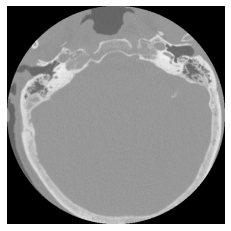

In [21]:
show_single(i)

In [22]:
def show_batch(cmap="gray"):
    """
    visualizes a batch of images
    """
    plt.figure(figsize=(16, 12))
    for i, img in enumerate(train_dataset.take(20)):  # iterate through the dataset
        plt.subplot(4, 5, i+1)
        show_single(img, cmap=cmap)
    plt.show()

#### A look of the images using different color maps

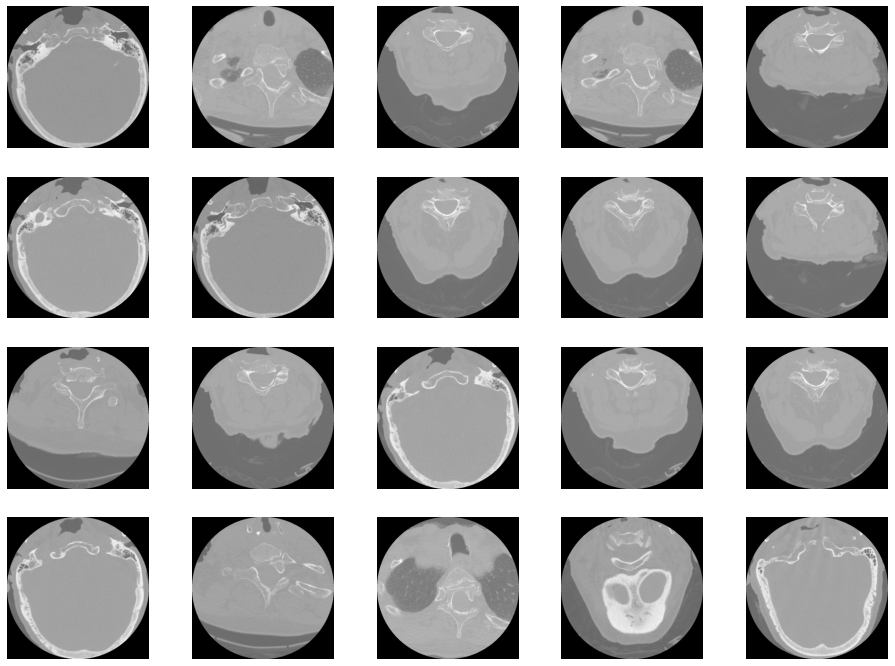

In [23]:
show_batch(cmap="gray")

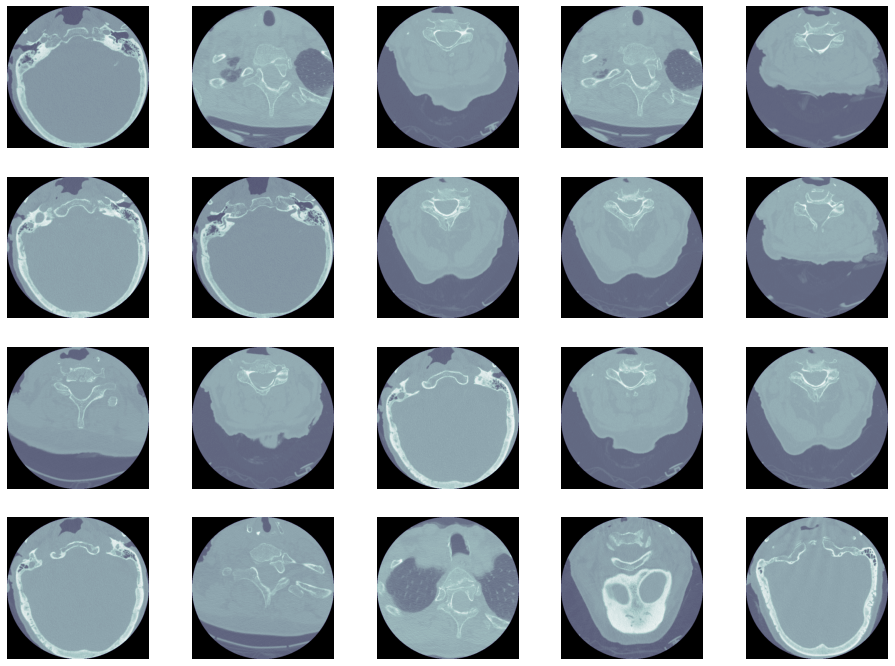

In [24]:
show_batch(cmap="bone")

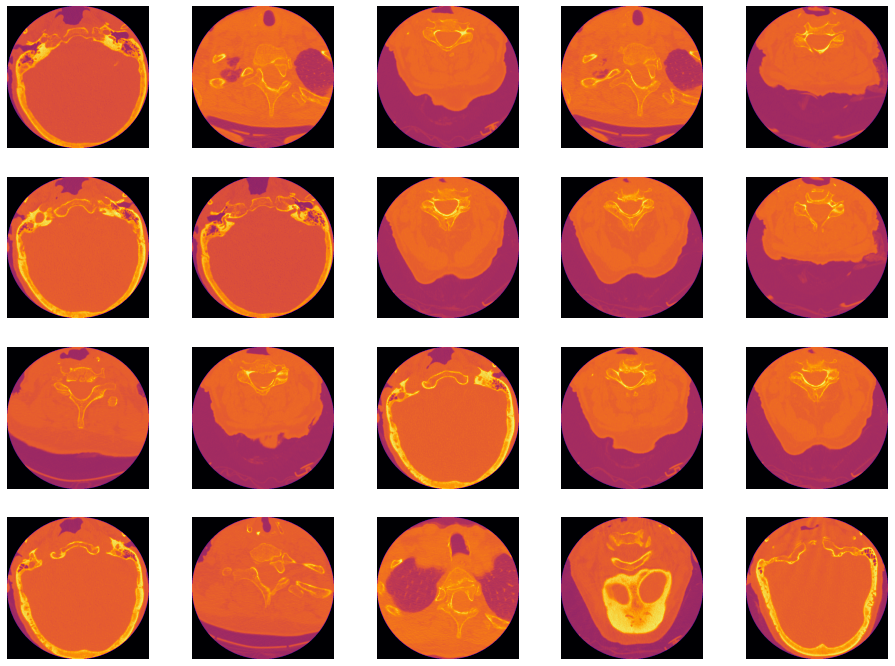

In [25]:
show_batch(cmap="inferno")

In [26]:
# lets modify the data generator, use 10 study instances
def data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[:5]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            train_labels = []
            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, (512, 512))
            #  normalize image
            img = img / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            train_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img, train_labels

In [27]:
train_data = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8))

In [28]:
train_data

<FlatMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int8)>

In [29]:
for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

(512, 512, 3)
(8,)
tf.Tensor([1 1 0 0 0 0 0 1], shape=(8,), dtype=int8)


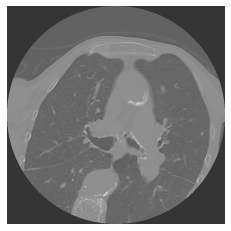

In [32]:
# visualize the image once again
show_single(img, cmap="gray")

### Split into train and validation

In [33]:
# we first need to know the number of data points we are dealing with
img_count = 0
for _, _ in enumerate(train_df.StudyInstanceUID[:5]):
    for _ in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
        img_count += 1
print(img_count)

1195


In [34]:
val_size = int(img_count * 0.2)
training = train_data.skip(val_size)
validation = train_data.take(val_size)

In [35]:
def configure_for_performance(data):
    data = data.cache()
#     data = data.shuffle(buffer_size=300)
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [36]:
training = configure_for_performance(training)
validation = configure_for_performance(validation)

# Modelling

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

In [38]:
# Define Alex Net model
def alex_net():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(512,512,3), kernel_size=(11,11),\
     strides=(4,4), padding='valid', activation="relu"))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(512*512*3,), activation="relu"))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer with 8 probability classes
    model.add(Dense(8, activation="softmax"))
    return model

In [39]:
model = alex_net()

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 96)      34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 384)       8

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

In [43]:
# training
history = model.fit(training, validation_data=validation,
                   epochs=epochs)

Epoch 1/10
94/94 [==============================] - 966s 10s/step - loss: 3.1189 - categorical_accuracy: 0.1324 - val_loss: 22.2880 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
94/94 [==============================] - 912s 10s/step - loss: 2.0009 - categorical_accuracy: 0.1686 - val_loss: 6.6207 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
94/94 [==============================] - 902s 10s/step - loss: 1.6662 - categorical_accuracy: 0.2000 - val_loss: 9.2649 - val_categorical_accuracy: 0.0000e+00
Epoch 4/10
94/94 [==============================] - 910s 10s/step - loss: 1.6079 - categorical_accuracy: 0.1766 - val_loss: 8.9456 - val_categorical_accuracy: 0.0000e+00
Epoch 5/10
94/94 [==============================] - 912s 10s/step - loss: 1.5313 - categorical_accuracy: 0.1773 - val_loss: 9.8794 - val_categorical_accuracy: 0.0000e+00
Epoch 6/10
94/94 [==============================] - 908s 10s/step - loss: 1.5123 - categorical_accuracy: 0.1672 - val_loss: 11.0766 - val_categorical

In [44]:
# visualize training 
def viz_loss(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    iters = [i for i in range(epochs)]
    
    plt.plot(iters, train_loss, label="Training Loss")
    plt.plot(iters, val_loss, label="Validation Loss")
    plt.title("A plot of Loss against number of iterations")
    plt.legend()
    plt.show()
    
def viz_acc(history):
    train_loss = history["categorical_accuracy"]
    val_loss = history["val_categorical_accuracy"]
    iters = [i for i in range(epochs)]
    
    plt.plot(iters, train_loss, label="Training Accuracy")
    plt.plot(iters, val_loss, label="Validation Accuracy")
    plt.title("A plot of Accuracy against number of iterations")
    plt.legend()
    plt.show()

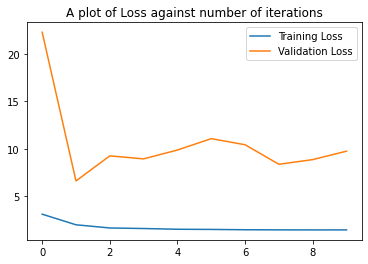

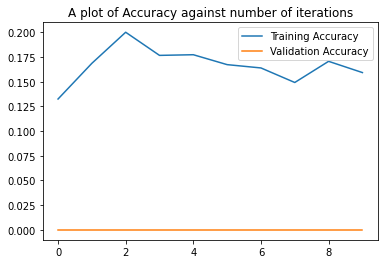

In [45]:
viz_loss(history.history)
viz_acc(history.history)